# Advanced tutorial

1. Dynamic execution in workflows
2. Checking explore with different values
3. Checking drift distributions

### Goal: Understand the dynamic execution and checking: drifting.

##  Problem: Clasify leaf specimens

This data set consists of a collection of features that measure shape and texture extracted from digital images of leaf specimens from a total of 40 different plant species. It was collected in February 2014 at the Faculty of Science, Universidade do Porto, Portugal.https://archive.ics.uci.edu/ml/datasets/leaf

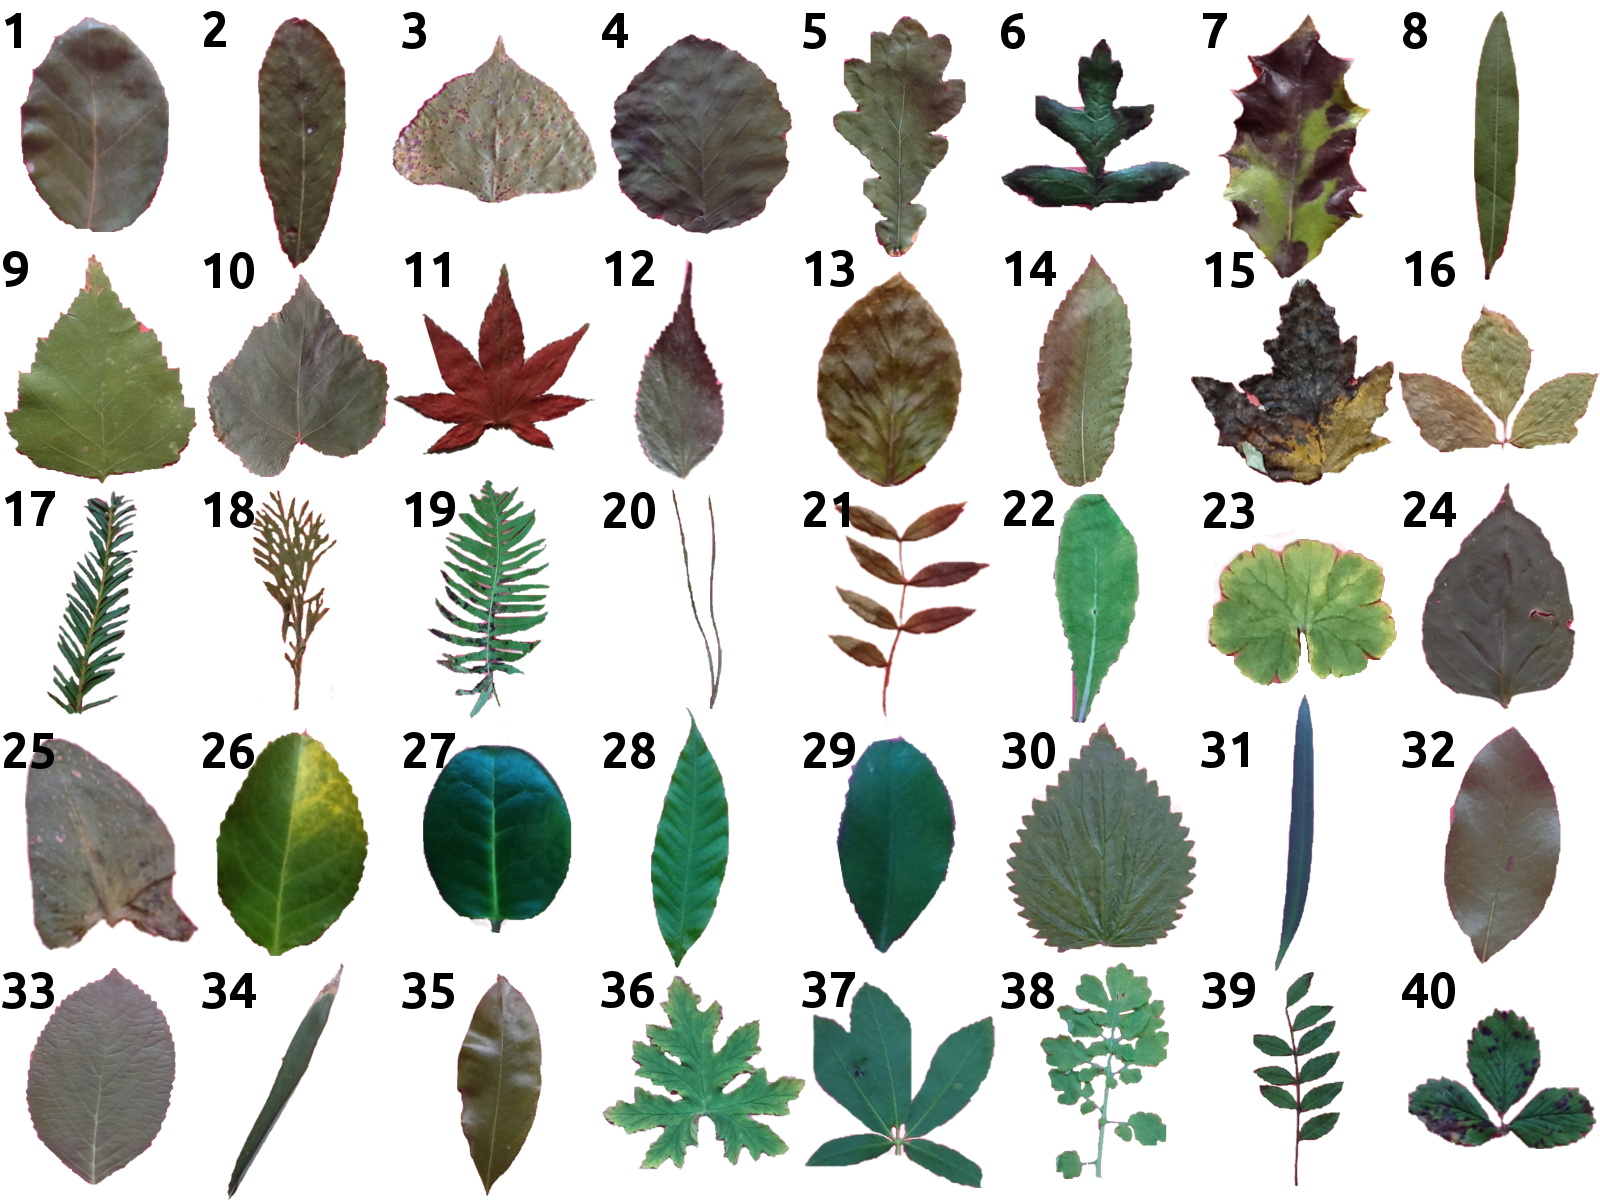

In [13]:
from IPython.display import Image
Image("pictures/plants.png", width=400, height=400)

## Build, start and run workflows

Build, start and run each environment inside each workflow


In [15]:
%%time

from autodeploy.setup import Setup, Executor, Tracker, Workflow
from autodeploy.deploy import Deploy

# App folder
app_dir = '/home/guess/Desktop/autodeploy/examples/demo2/data-science/'


n_estimators = [3, 5, 7]
percentage_data = [0.6, 0.8, 1]

for n_estimator in n_estimators: 
    for p_data in percentage_data:
        executors1 = [Executor(name='gathering', 
                               file='gathering.py',
                               dockerfile='Dockerfile_gathering',
                               parameters={'raw_data_path': 'leaf.csv',
                                            'percentage': p_data}),

                      Executor(name='preprocessing', 
                               file='preprocessing.py',
                               requirements='req_preprocessing.txt')]

        workflow1 = Workflow(name='workflow1', 
                             executors=executors1,
                             tracker=Tracker(port=8001))

        executors2 = [Executor(name='modeling', 
                              file='modeling.py',
                              parameters={'preprocessed_data': 'preprocessed_data.csv',
                                          'model_path': 'models',
                                          'n_estimators': n_estimator},
                              requirements='req_modeling.txt'),
                      
                      Executor(name='modeling2', 
                              file='modeling2.py',
                              parameters={'preprocessed_data': 'preprocessed_data.csv',
                                          'model_path': 'models2',
                                          'n_estimators': n_estimator+2},
                              requirements='req_modeling.txt')]
        # Parallel
        workflow2 = Workflow(name='workflow2', 
                             executors=executors2,
                             tracker=Tracker(port=8002),
                             parallel=True)

        workflower = Setup(app_dir, workflows=[workflow1, workflow2],
                                     verbose=False)

        # Build the nodes
        workflower.build_workflows()

        # Start containers and run workflows
        deployer = Deploy(app_dir, workflower, verbose=False)

        deployer.start_workflows()
        deployer.run_workflows()

100%|██████████| 2/2 [00:04<00:00,  2.19s/it]

CPU times: user 1.04 s, sys: 381 ms, total: 1.42 s
Wall time: 47.7 s


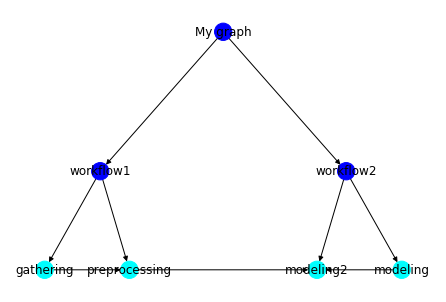

In [2]:
workflower.draw_workflow('My graph')

# Get tracked values

In [16]:
from autodeploy.track import Tracker


app_dir = '/home/guess/Desktop/autodeploy/examples/demo2/data-science/'
tracker = Tracker(app_dir)
df = tracker.get_tracked_values(workflow_name='workflow2')
df.head(2)

end_time  metrics.test_acc  \
0 2020-02-25 14:09:06.812000+00:00             0.706   
1 2020-02-25 14:09:06.797000+00:00             0.691   

  params.n_estimators_model params.random_state_model  \
0                         9                        42   
1                         7                        42   

  params.random_state_split params.test_percentage params.x_test_len  \
0                        42                    0.2                68   
1                        42                    0.2                68   

  params.x_train_len                            run_id  \
0                272  aa5bf3d5afc747759266baba9d3e4fa3   
1                272  ea5b7bc71596439d940a7e6008228e7c   

                        start_time tags.mlflow.runName tags.mlflow.source.name  
0 2020-02-25 14:09:06.476000+00:00           modeling2            modeling2.py  
1 2020-02-25 14:09:06.461000+00:00            modeling             modeling.py

## Get artifacts

In [4]:
tracker.list_artifacts('workflow2', run_id='dcc1b2f29a5447039011b022d110d7ed')

['/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/dcc1b2f29a5447039011b022d110d7ed/artifacts/y_train.csv',
 '/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/dcc1b2f29a5447039011b022d110d7ed/artifacts/X_test.csv',
 '/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/dcc1b2f29a5447039011b022d110d7ed/artifacts/X_train.csv',
 '/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/dcc1b2f29a5447039011b022d110d7ed/artifacts/y_test.csv',
 '/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/dcc1b2f29a5447039011b022d110d7ed/artifacts/models2']

## Get tracker url

In [12]:
tracker.get_tracker_url('workflow2')

'http://localhost:8002/'

## Open tracker ui

In [13]:
tracker.open_browser('workflow2')

# Check tracked values

In [17]:
from autodeploy.check import Checker


checker = Checker(tracker)
checker


Checker = (
    Tracker = (
        Workflows: ['workflow1', 'workflow2']
        App directory: /home/guess/Desktop/autodeploy/examples/demo2/data-science/
    )
)

In [18]:
checker.explore(df[['metrics.test_acc', 'params.n_estimators_model', 'params.x_train_len']].copy(),
                minimal=False)

# Deploy a model for prediction

In [20]:
artifacts = tracker.list_artifacts('workflow2', run_id='dcc1b2f29a5447039011b022d110d7ed')
artifacts

['/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/dcc1b2f29a5447039011b022d110d7ed/artifacts/y_train.csv',
 '/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/dcc1b2f29a5447039011b022d110d7ed/artifacts/X_test.csv',
 '/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/dcc1b2f29a5447039011b022d110d7ed/artifacts/X_train.csv',
 '/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/dcc1b2f29a5447039011b022d110d7ed/artifacts/y_test.csv',
 '/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/dcc1b2f29a5447039011b022d110d7ed/artifacts/models2']

In [21]:
%%time

from autodeploy.deploy import Deploy

# App folder1
app_dir = '/home/guess/Desktop/autodeploy/examples/demo2/data-eng/'
# model_path = '/home/guess/Desktop/autodeploy/examples/demo2/data-science/workflow/models'
model_path = artifacts[-1] # you can choose the path from the artifact path

# Read the platform
deployer_eng = Deploy(app_dir, verbose=True)

# Build a predictor, if there is not an image, build a new one
deployer_eng.build_predictor(image='predictor', model_path=model_path)

# Run predictor, provides name and port for the container.
deployer_eng.run_predictor(name='predictor', port=5001)

deployer_eng

25-Feb-20 15:10:38 -  INFO - [++] Building predictor [image:predictor] as API. Please wait.
25-Feb-20 15:10:38 -  WARNING - [+] Image [predictor] already exists.
25-Feb-20 15:10:38 -  INFO - [+] Predictor: predictor loaded successfully.
25-Feb-20 15:10:38 -  INFO - [++] Running predictor [predictor].
25-Feb-20 15:10:38 -  WARNING - [+] Environment: [predictor] is already running.
25-Feb-20 15:10:38 -  INFO - [+] Predictor API at [http://localhost:5001]. 


CPU times: user 13.9 ms, sys: 2.92 ms, total: 16.8 ms
Wall time: 25.9 ms



Predictor = (
    Name: predictor,
    Environment(image): <Image: 'app_single_api:latest', 'predictor:latest'>,
    Container: None,
    URL=0.0.0.0:5001),

In [24]:
!curl 0.0.0.0:5001

{}

In [32]:
# deployer_eng.stop_predictor()

## Use the deployed model for predicting

In [25]:
%%time

import pandas as pd
import os

from autodeploy.check import tools
from autodeploy.setup import Setup, Executor, Tracker, Workflow
from autodeploy.run import Run
from autodeploy.deploy import Deploy

# App folder
app_dir = '/home/guess/Desktop/autodeploy/examples/demo2/data-eng/'

# Simulate new requests from user
df_input = pd.read_csv(os.path.join(app_dir, 'workflow', 'X_test.csv'))
df_noise = tools.add_noise(df_input, sigma=0.003) # Predictions drawn from drafted distribution
# df_noise = df_input
df_noise.to_csv(os.path.join(app_dir, 'workflow', 'new_data.csv'), index=False)

# Workflows

executors3 = [Executor(name='get_new_data', 
                       file='get_new_data.py',
                       parameters={'new_data_path': 'new_data.csv'},
                       env='gathering'),
              Executor(name='preprocessing_new_data', 
                       file='preprocessing_new_data.py',
                       parameters={'output_data': 'preprocessed_data.csv'},
                       env='preprocessing')]
# Sequential
workflow3 = Workflow(name='workflow3', 
                     executors=executors3,
                     tracker=Tracker(port=8003))



# Build and run environments (containers)
# workflow_dataeng = Setup(app_dir, workflows_eng, verbose=False)
workflow_dataeng = Setup(app_dir, workflows=[workflow3],
                             verbose=False)
workflow_dataeng.run_pipeline()

# Read the workflows and run them
runner_eng = Run(workflow_dataeng, verbose=True)
runner_eng.run_workflows()

# Make predictions
deployer_eng = Deploy(app_dir, verbose=True)
predictions = deployer_eng.predict('preprocessed_data.csv', port=5001)

predictions.head()

25-Feb-20 15:10:52 -  INFO - [++] Running workflow: [workflow3].
25-Feb-20 15:10:52 -  INFO - [+] Running env: [workflow3:get_new_data].
25-Feb-20 15:10:54 -  INFO - [+] Running (get_new_data.py). 
25-Feb-20 15:10:54 -  INFO - [+] Output:     eccentricity  aspect_ratio  elongation  ...  third_moment  uniformity   entropy
0      0.992120     10.122007    0.926626  ...     -0.002020    0.001952  0.273088
1      0.499959      1.129348    0.671957  ...     -0.000188    0.002303  0.670938
2      0.238379      1.046489    0.604313  ...      0.008805    0.001629  0.832928
3      0.861264      1.878176    0.619602  ...      0.001829    0.001123  1.012857
4      0.832621      1.982177    0.511053  ...      0.011049    0.003197  1.800648

[5 rows x 14 columns]
 
25-Feb-20 15:10:54 -  INFO - [+] Environment (get_new_data) finished successfully. 
25-Feb-20 15:10:54 -  INFO - [+] Running env: [workflow3:preprocessing_new_data].
25-Feb-20 15:10:56 -  INFO - [+] Running (preprocessing_new_data.py). 


CPU times: user 129 ms, sys: 32 ms, total: 161 ms
Wall time: 4.16 s


eccentricity  aspect_ratio  elongation  solidity  stochastic_convexity  \
0      0.992120     10.122007    0.926626  0.807773              0.904037   
1      0.499959      1.129348    0.671957  0.533847              0.749344   
2      0.238379      1.046489    0.604313  0.564040              0.794396   
3      0.861264      1.878176    0.619602  0.819642              0.852173   
4      0.832621      1.982177    0.511053  0.940961              0.997775   

   isoperimetric_factor  maximal_indentation_depth  lobedness  \
0              0.151279                   0.119021   2.733442   
1              0.158390                   0.130897   3.079675   
2              0.218673                   0.124770   2.850208   
3              0.332727                   0.051282   0.400782   
4              0.558868                   0.022987   0.118528   

   average_intensity  average_contrast  smoothness  third_moment  uniformity  \
0           0.011378          0.054723    0.002777     -0.002020    0.001952   
1           0.010207          0.054657    0.011572     -0.000188    0.002303   
2           0.039054          0.121152    0.009723      0.008805    0.001629   
3           0.041787          0.109958    0.015188      0.001829    0.001123   
4           0.079915          0.167644    0.027361      0.011049    0.003197   

    entropy  pred  
0  0.273088    31  
1  0.670938    11  
2  0.832928    11  
3  1.012857     5  
4  1.800648    12

In [34]:
# workflow_dataeng.stop_workflows()

In [11]:
predictions['pred'].head()

0    31
1    11
2    11
3     5
4    12
Name: pred, dtype: int64

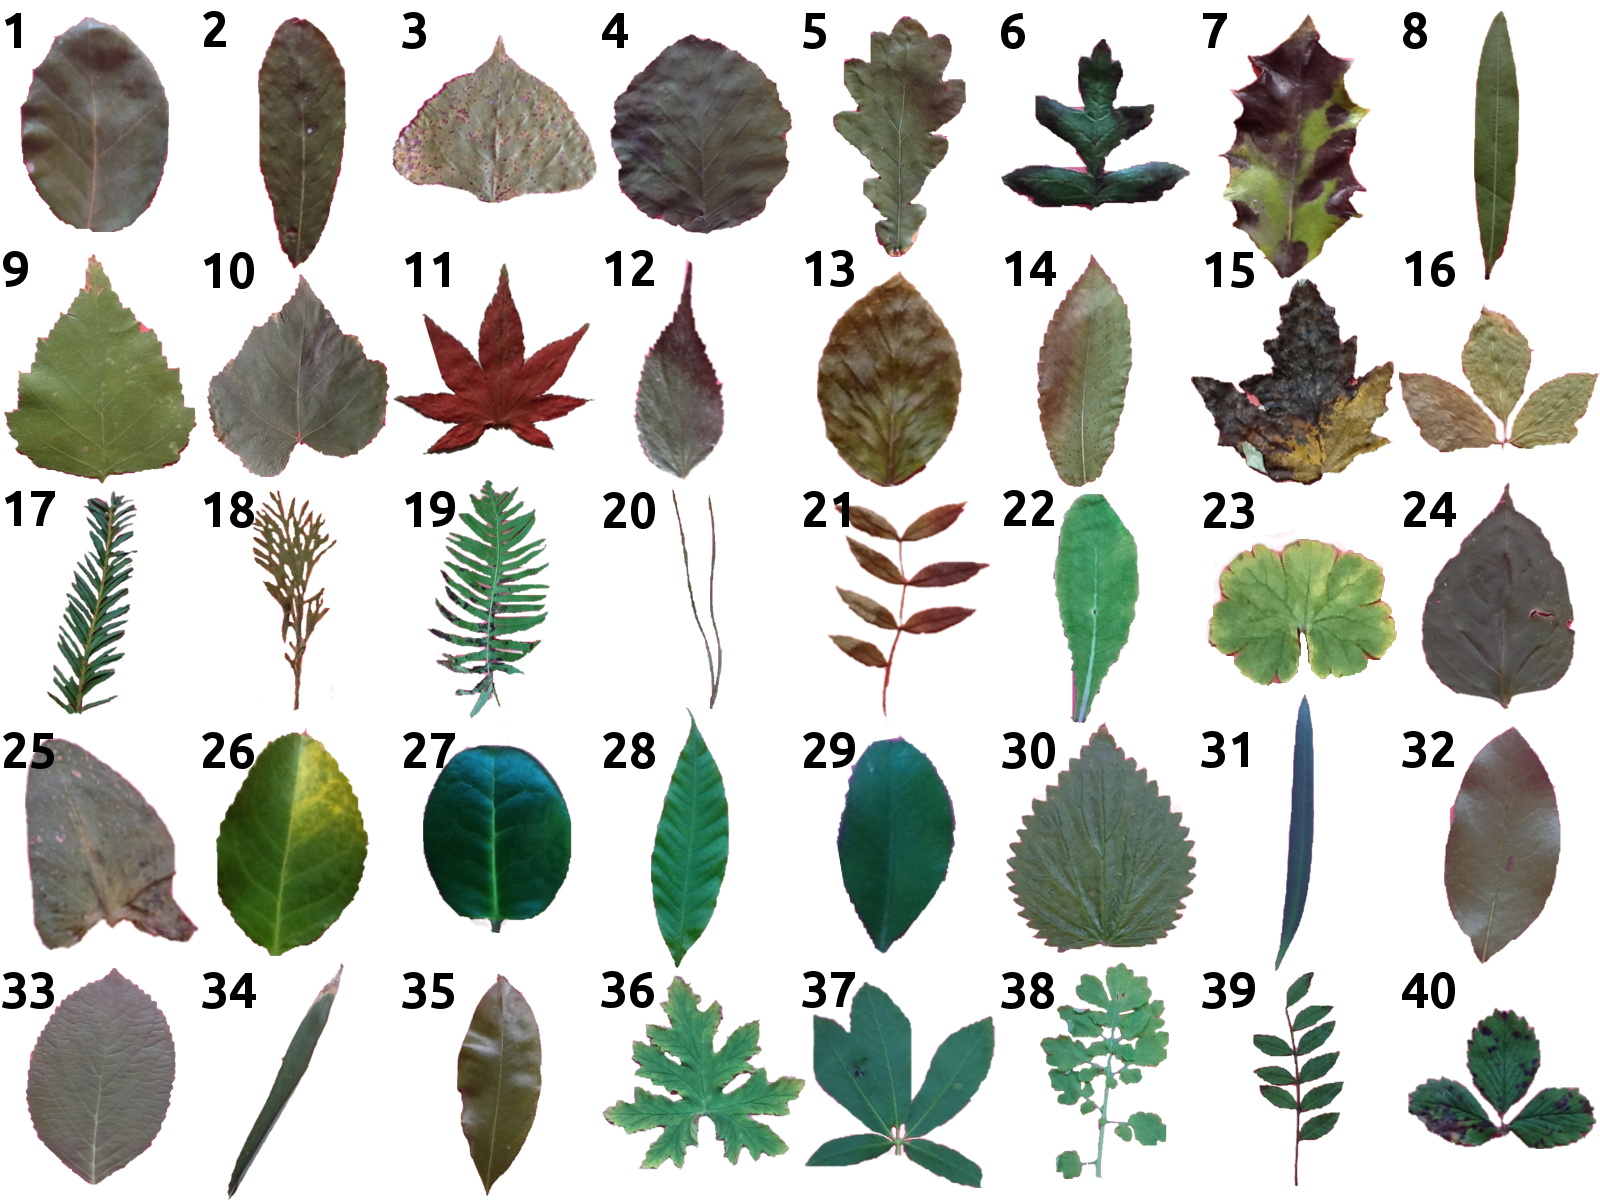

In [14]:
from IPython.display import Image
Image("pictures/plants.png", width=400, height=400)

## Drift distribution

In [28]:
import pandas as pd
from autodeploy.track import Tracker

app_dir = '/home/guess/Desktop/autodeploy/examples/demo2/data-science/'
tracker = Tracker(app_dir)
X_train_path = tracker.list_artifacts('workflow2', '3b62bfbb88034c30bca7aa12787d43b4')[2]
X_train = pd.read_csv(X_train_path)
X_train.head(2)

eccentricity  aspect_ratio  elongation  solidity  stochastic_convexity  \
0       0.87163        2.0659     0.55339   0.94868                1.0000   
1       0.39092        1.0870     0.68174   0.50961                0.6614   

   isoperimetric_factor  maximal_indentation_depth  lobedness  \
0               0.60231                   0.031671    0.18255   
1               0.15361                   0.140820    3.60930   

   average_intensity  average_contrast  smoothness  third_moment  uniformity  \
0           0.049706          0.134400    0.017742      0.006692    0.000161   
1           0.028638          0.089135    0.007882      0.002118    0.000210   

   entropy  
0  1.40160  
1  0.90082

In [29]:
tracker.list_artifacts('workflow2', '3b62bfbb88034c30bca7aa12787d43b4')

['/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/3b62bfbb88034c30bca7aa12787d43b4/artifacts/y_train.csv',
 '/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/3b62bfbb88034c30bca7aa12787d43b4/artifacts/X_test.csv',
 '/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/3b62bfbb88034c30bca7aa12787d43b4/artifacts/X_train.csv',
 '/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/3b62bfbb88034c30bca7aa12787d43b4/artifacts/y_test.csv',
 '/home/guess/Desktop/autodeploy/examples/demo2/data-science/ad-stuff/ad-tracker/tracker-workflow2/mlruns/0/3b62bfbb88034c30bca7aa12787d43b4/artifacts/models2']

/home/guess/anaconda3/envs/venv2/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning:

Trying to unpickle estimator MinMaxScaler from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

/home/guess/anaconda3/envs/venv2/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning:

Trying to unpickle estimator MinMaxScaler from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.



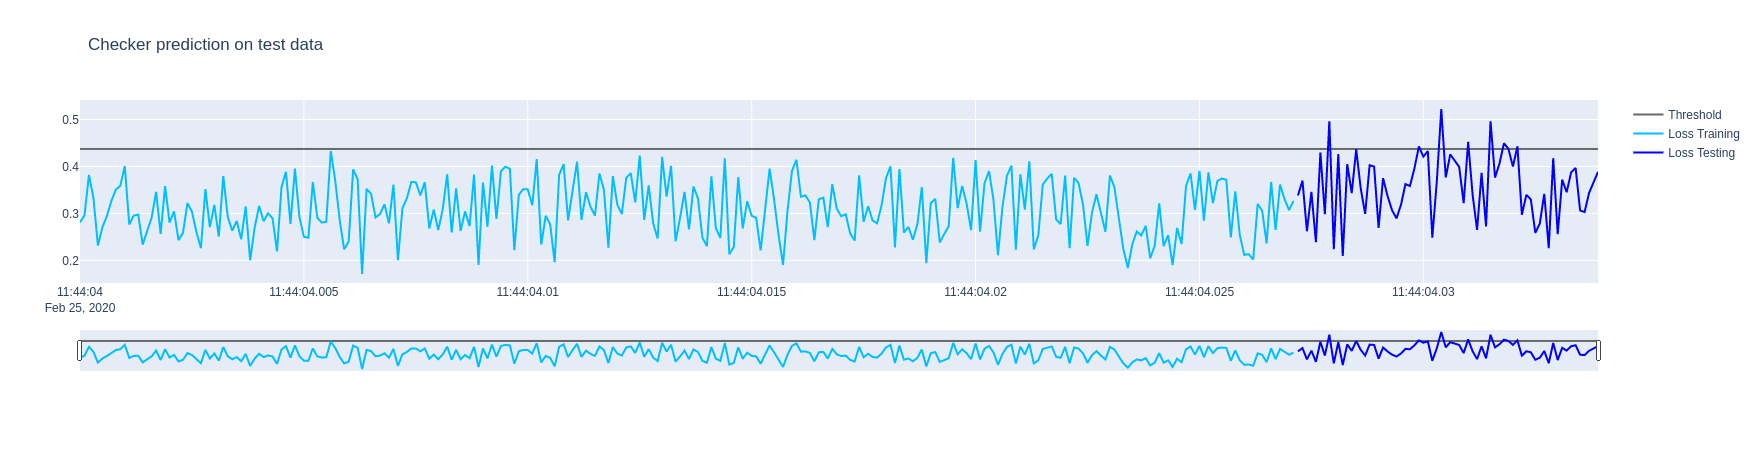

25-Feb-20 12:09:51 -  INFO - [+] Checker for file: [/home/guess/Desktop/autodeploy/examples/demo2/data-eng/ad-stuff/ad-checker/predictions/input_predictions_2020_02_25_11_44_04.csv] was run successfully.


CPU times: user 589 ms, sys: 4.5 ms, total: 594 ms
Wall time: 610 ms


In [8]:
%%time

import os
import pandas as pd
from autodeploy.check import check

app_dir = '/home/guess/Desktop/autodeploy/examples/demo2/data-eng/'
tracker = Tracker(app_dir)
checker = Checker(tracker)

X_train = pd.read_csv(os.path.join(app_dir, 'workflow', 'X_train.csv'))

checker.drift_distribution(X_train.copy(), checker_type='dd_autoencoder', verbose=True,)



In [ ]:
feedback.json

anomaly: x_train.csv
range: x_train[10:100]
date: february
severity: 30


In [ ]:
# action from user: data scientist:

- change model1 -> model2.
- rebuild the current model with tota data (old data + new data)
- 


## Future work:  Module for Interaction

Goal: help to improve the model with human interaction.

Examples:

- Feedbacks predictions: label wrong predictions.
- Rebuild a model with augmented data.
- Remove not useful features from data, because they are not so 
  important anymore.
- 

Ideas:
- Active learning and preference learning
- Transparency and feedback in ML
- Human-in-the-loop intelligent systems
- Human centred learning

Example: 


https://sites.google.com/site/ijcai2016iml/call-for-papers

https://poloclub.github.io/

https://www.youtube.com/watch?v=llub5GcOF6w&feature=youtu.be

http://hcml2016.goldsmithsdigital.com/